# Task Details
Create a model to access the likelihood of a death by heart failure event.
This can be used to help hospitals in assessing the severity of patients with cardiovascular diseases.

# ოთხი ეტაპი:
    1. მონაცემთა ანალიზი და ვიზუალიზაცია
    2. მონაცემთა გარდაქმნა
    3. მოდელის იმპლემენტაცია
    4. ოპტიმიზაცია

ბიბლიოთეკები:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sns
from scipy import stats
%matplotlib inline

# 1. მონაცემთა ანალიზი და ვიზუალიზაცია

In [2]:
import os
data = pd.read_csv('heart_failure_clinical_records_dataset.csv')
data.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


--------------------------------------------------------------------------------------------------------------------------------
# ეტაპი 1: 
ფიჩერების რაოდენობა, ცვლადების რაოდენობა


In [3]:
data.shape

(299, 13)

--------------------------------------------------------------------------------------------------------------------------------
# ეტაპი 2: 
შევამოწმოთ ფიჩერები შეიცავენ თუ არა null ცვლადებს, თუ კი რა პროცენტობით.


In [4]:
for col in data.columns:
    nullOrNot = data[col].isnull()
    nullNumber = nullOrNot.sum()
    print(col, str(nullNumber / len(data[col]) * 100) + '%')

age 0.0%
anaemia 0.0%
creatinine_phosphokinase 0.0%
diabetes 0.0%
ejection_fraction 0.0%
high_blood_pressure 0.0%
platelets 0.0%
serum_creatinine 0.0%
serum_sodium 0.0%
sex 0.0%
smoking 0.0%
time 0.0%
DEATH_EVENT 0.0%


--------------------------------------------------------------------------------------------------------------------------------
# ეტაპი 3: 
ვნახოთ კატეგორიული ცვლადები გვაქვს თუ არა (რადგან თუ გვაქვს შემდგომში დაგვჭირდება რიცხვითში, ან ვექტორულში გადაყვანა).


In [5]:
data.dtypes

age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
high_blood_pressure           int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
DEATH_EVENT                   int64
dtype: object

continuous ფიჩერები გვაქვს - age,features platelets and serum_creatinine.

In [6]:
data.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


კატეგორიზაციის ცვლადები უკვე int64-ითაა (კონკრეტულად კი 0/1 -ით) წარმოდგენილი.

In [7]:
cat_cols=list()
num_cols=list()
for col in data.columns:
    if np.all((data[col] == 1) | (data[col] == 0)):
        cat_cols.append(col)
    else:
        num_cols.append(col)

ამ თვისებით განვაცალკევე ორ ლისტად (კატეგორიულად და "რიცხვითად").

--------------------------------------------------------------------------------------------------------------------------------
# ეტაპი 4: 
კონკრეტული ფიჩერების რაოდენობრივ განაწილებაზე დაკვირვება


დავაკვირდეთ აზრობრივად ნომინალურ ცვლადებს (0/1) და ინფორმაციის რაოდენობას


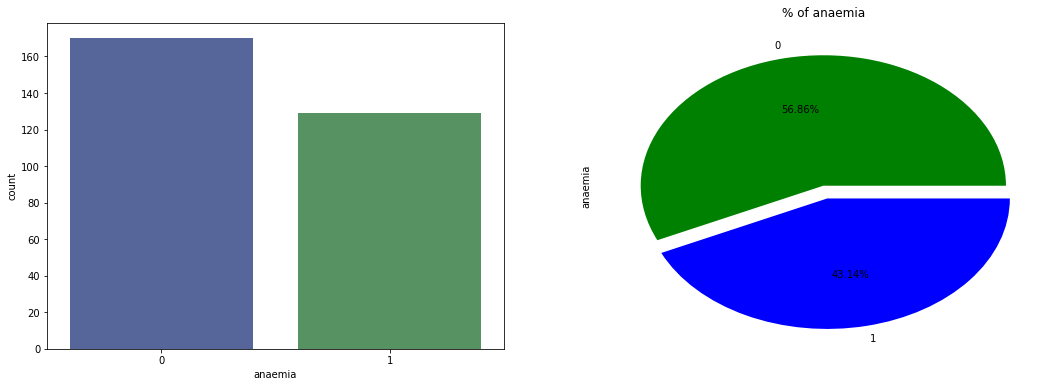

In [8]:
f, ax  = plt.subplots(1,2,figsize = (18,6))
sns.countplot(data['anaemia'],ax=ax[0],palette = 'dark',alpha=0.7)

loan_status_count = data['anaemia'].value_counts(normalize=True)
loan_status_count.plot.pie(colors=['green', 'blue'], autopct="%.2f%%",explode = [0,0.1],ax=ax[1])
plt.title('% of anaemia')
plt.show()

პროცენტულად ძალიან მცირე განსხვავებაა, რაც დასწავლისთვის გამოსადეგი იქნება. ეს ფიჩერი საკმაოდ დაბალანსებულია.


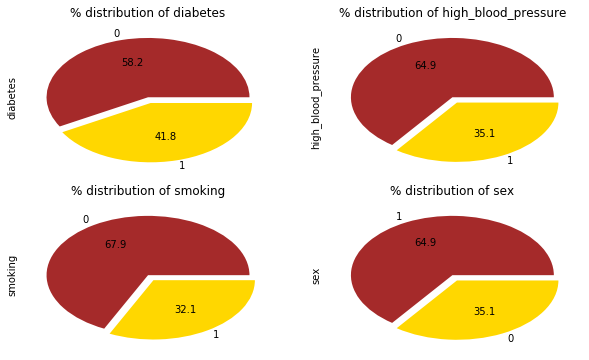

In [9]:
plt.figure(1,figsize=(16,7))

plt.subplot(221)
data['diabetes'].value_counts().plot.pie(title='% distribution of diabetes',figsize=(10,6),colors=['brown', 'gold'],autopct="%0.1f",explode=[0,.1])

plt.subplot(222)
data['high_blood_pressure'].value_counts().plot.pie(title='% distribution of high_blood_pressure',colors=['brown', 'gold'],autopct="%0.1f",explode=[0,.1])

plt.subplot(223)
data['smoking'].value_counts().plot.pie(title='% distribution of smoking',colors=['brown', 'gold'],autopct="%0.1f",explode=[0,.1])

plt.subplot(224)
data['sex'].value_counts().plot.pie(title='% distribution of sex',colors=['brown', 'gold'],autopct="%0.1f",explode=[0,.1])
plt.show()

აქაც ჩანს რომ დიაბეტის ქონდა არ ქონა მონაცემებში თანაბრადაა თითქმის განაწილებული, ანუ დაბალანსებულია, თუმცა დანარჩენი სამი არც ისე თანაბრადაა (ნაკლებადაა დაბალანსებული), თუმცა თითოეული 30%-ზე მეტია.
ეს ფაქტორი საგულისხმო(საბედისწეროც) შეიძლება გახდეს test და train ნაწილებად დაყოფის დროს.


0.42306190672863536


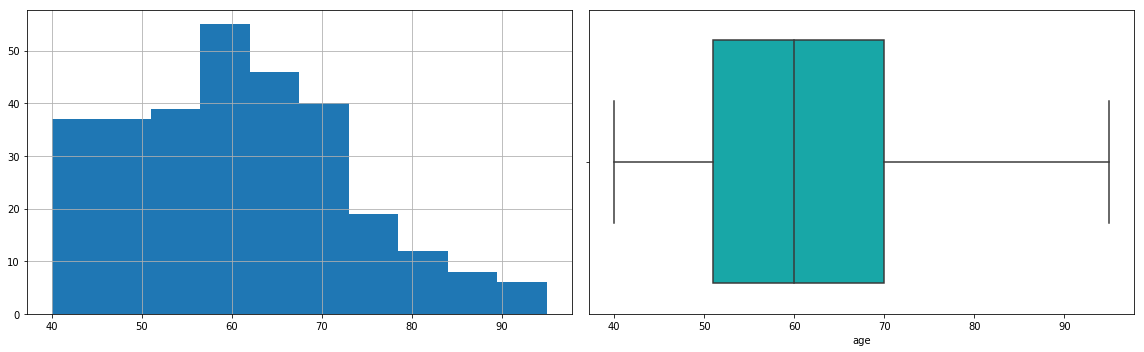

In [10]:
plt.figure(1,figsize=(16,5))
plt.subplot(121)
print(data['age'].skew())
data['age'].hist();
plt.subplot(122)
sns.boxplot(data['age'],color='c')
fig = plt.gcf()
plt.tight_layout()

* ასაკის skew-ness არის მარცხნივ 0.42306190672863536 ამდენით.
* არ შეიცავს outlier-ებს რაც კარგია.
* უმეტესობა მონაცემებისა დაახლობით ახლოსაა 60-თან.
* ამის მიზეზი შეიძლება სავარაუდოდ ისაა, რომ 70-ზე მეტი ასაკის მოსახლეობა უფრო ცოტაა (მერე ცოტა ცოცხლობს უფრო)
* ასევე შევამჩნევთ რომ 40 არის მინიმალური, ამის მიზეზი ისაა რომ ანემია არ აწუხებთ ახალგაზრდებს.



4.463110084653752


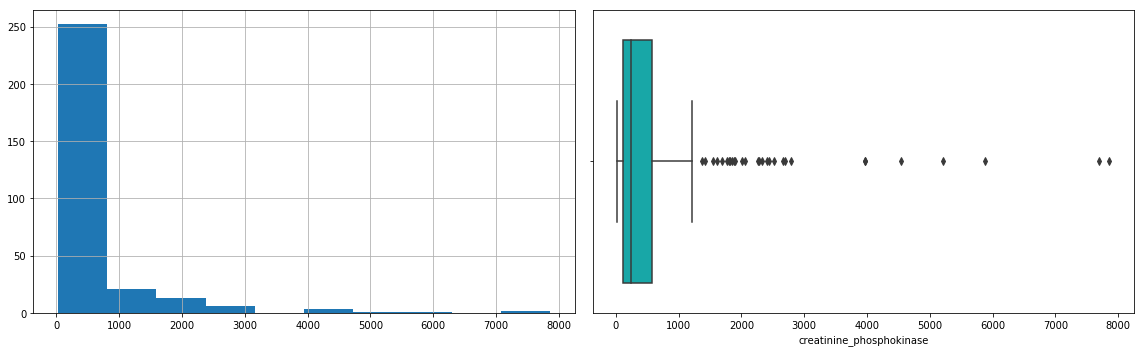

In [11]:
plt.figure(1,figsize=(16,5))
plt.subplot(121)
print(data['creatinine_phosphokinase'].skew())
data['creatinine_phosphokinase'].hist();
plt.subplot(122)
sns.boxplot(data['creatinine_phosphokinase'],color='c')
fig = plt.gcf()
plt.tight_layout()

* creatinine_phosphokinase-is skew-ness არის მარცხნივ 4.463110084653752, რაც გამოსასწორებელია (დიაგრამაშიც კი ეტყობოდა).
* შეიცავს დიდი რაოდენობით outlier-ებს რაც ცუდია.
* უმეტესობა მონაცემებისა დაახლობით ახლოსაა 200-250-თან (ამ დროს საშუალო ორჯერ მეტია) :(.
* log transformation-შეგვიძლია გამოვიყენოთ ამ დროს და skewness-საც გავაქრობ.
პ.ს. log transformation` is a convenient means of transforming a highly skewed variable into a more normalized dataset.


0.5553827516973211


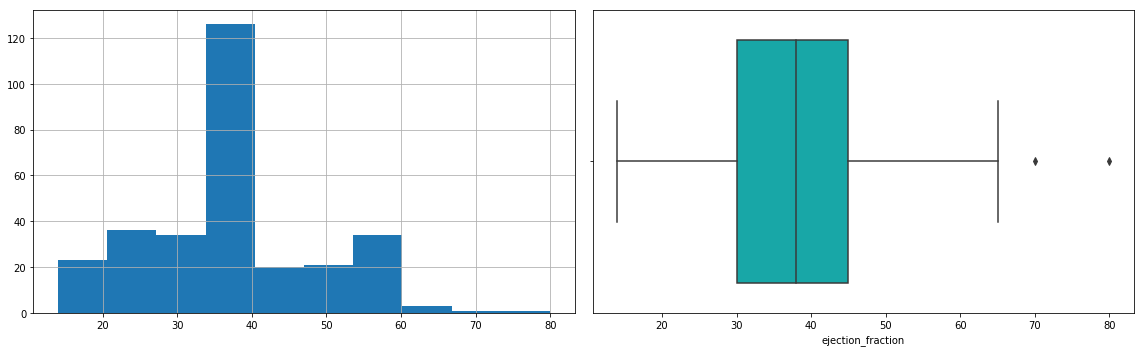

In [12]:
plt.figure(1,figsize=(16,5))
plt.subplot(121)
print(data['ejection_fraction'].skew())
data['ejection_fraction'].hist();
plt.subplot(122)
sns.boxplot(data['ejection_fraction'],color='c')
fig = plt.gcf()
plt.tight_layout()

* ejection_fraction-ის skew-ness არის მარცხნივ 0.5553827516973211 ამდენით.
* შეიცავს outlier-ებს რამდენიმეს მხოლოდ.
* უმეტესობა მონაცემებისაა დაახლობით ახლოსაა 36-თან.



1.4623208382757793


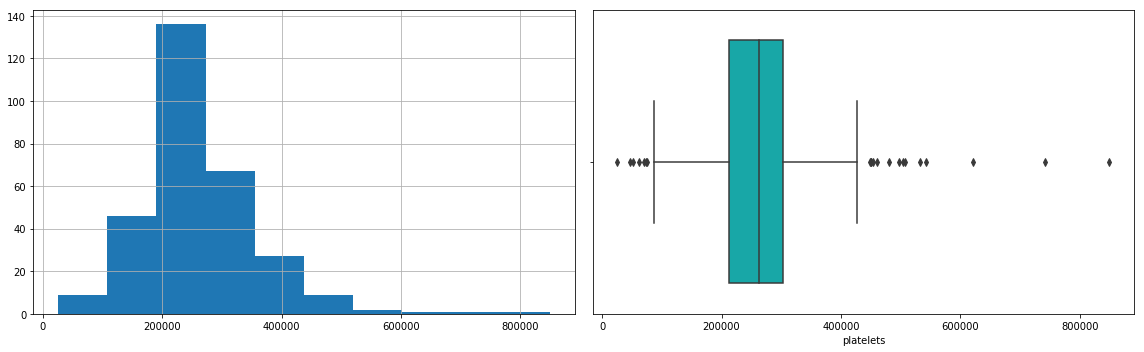

In [13]:
plt.figure(1,figsize=(16,5))
plt.subplot(121)
print(data['platelets'].skew())
data['platelets'].hist();
plt.subplot(122)
sns.boxplot(data['platelets'],color='c')
fig = plt.gcf()
plt.tight_layout()

* platelets-ის skew-ness არის მარცხნივ 1.4623208382757793 ამდენით.
* შეიცავს outlier-ებს ბევრს, როგორც მარცხნიდან ისე მარჯვნიდან.
* უმეტესობა მონაცემებისაა დაახლობით ახლოსაა 230000-თან.
* მონაცემები მარცხნივაა გადახრილი.



4.455995882049026


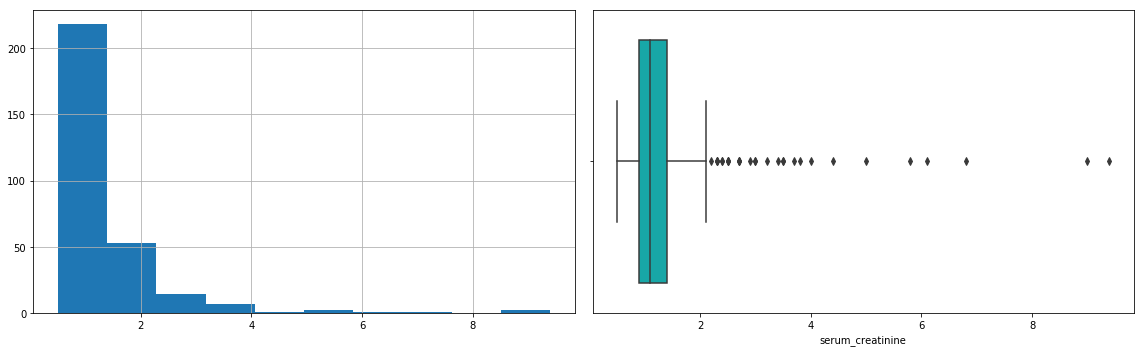

In [14]:
plt.figure(1,figsize=(16,5))
plt.subplot(121)
print(data['serum_creatinine'].skew())
data['serum_creatinine'].hist();
plt.subplot(122)
sns.boxplot(data['serum_creatinine'],color='c')
fig = plt.gcf()
plt.tight_layout()

* serum_creatinine-ის skew-ness არის მარცხნივ 4.455995882049026 ამდენით, რაც აუცილებრად გამოსასწორებელია.
* შეიცავს outlier-ებს ბევრს მარჯვნიდან.
* უმეტესობა მონაცემებისაა დაახლობით ახლოსაა 1-თან.



-1.0481360160574988


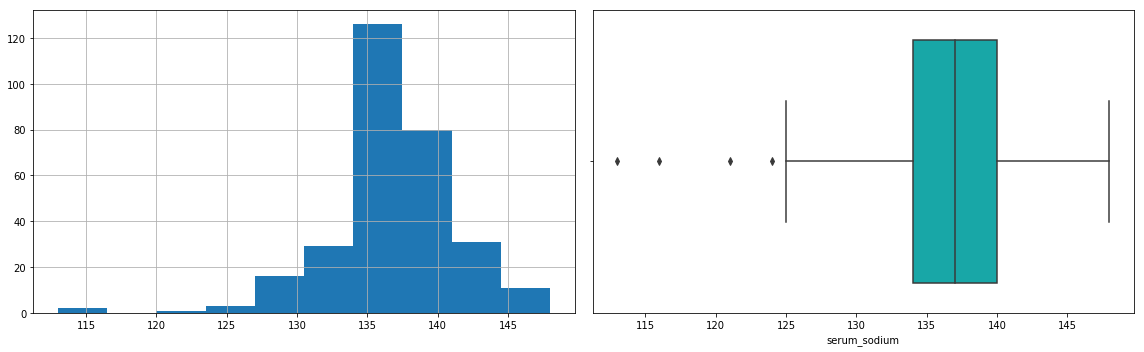

In [15]:
plt.figure(1,figsize=(16,5))
plt.subplot(121)
print(data['serum_sodium'].skew())
data['serum_sodium'].hist();
plt.subplot(122)
sns.boxplot(data['serum_sodium'],color='c')
fig = plt.gcf()
plt.tight_layout()

* serum_creatinine-ის skew-ness არის მარჯვნივ -1.0481360160574988 ამდენით.
* შეიცავს outlier-ებს რამდენიმე მარცხნიდან.
* უმეტესობა მონაცემებისაა დაახლობით ახლოსაა 137-თან.


0.12780264559841184


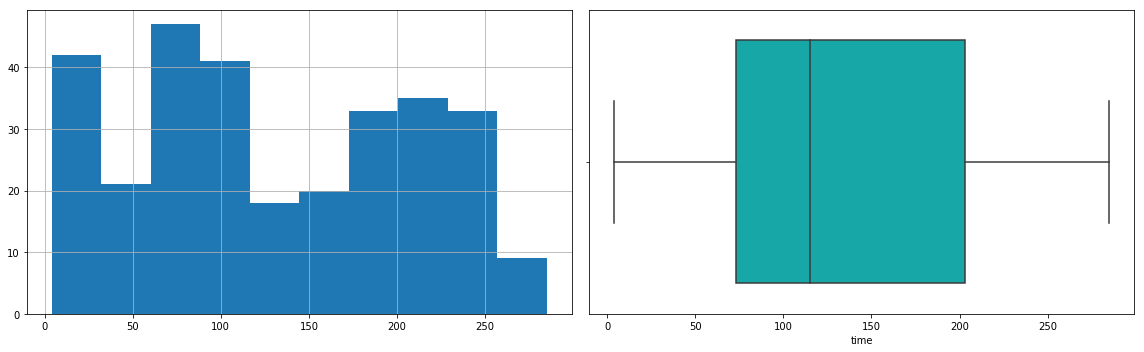

In [16]:
plt.figure(1,figsize=(16,5))
plt.subplot(121)
print(data['time'].skew())
data['time'].hist();
plt.subplot(122)
sns.boxplot(data['time'],color='c')
fig = plt.gcf()
plt.tight_layout()

* serum_creatinine-ის skew-ness არის მარცხნივ 0.12780264559841184 ამდენით.
* არ შეიცავს outlier-ებს.
* მონაცემები დაუდგენლადაა გაფანტული. ჩანს არაა დრო რაიმე ინფორმაციის მატარებელი. ეს დასადროპია.

--------------------------------------------------------------------------------------------------------------------------------
# ეტაპი 5: 
## ბივარიანტული ანალიზი (Bivariate Analysis)


# - კატეგორიული ფიჩერები & TARGET

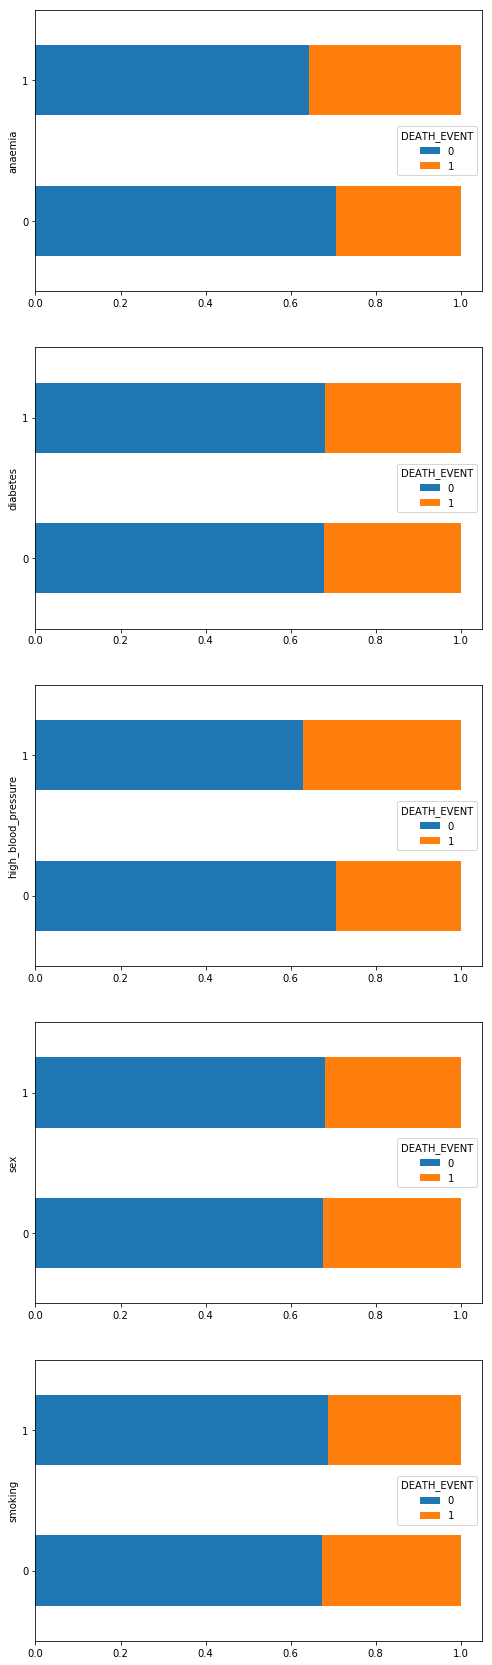

In [17]:
target = 'DEATH_EVENT'
cat_cols_ = cat_cols[:len(cat_cols)-1]
fig,ax = plt.subplots(len(cat_cols_),1,figsize=(8,6*len(cat_cols_)))

for i,col in enumerate(cat_cols_):
    pd.crosstab(data[col],data[target])
    ct = pd.crosstab(data[col],data[target],normalize="index")
    ct.plot.barh(stacked=True,ax=ax[i])
    
plt.show()

აქედან ჩანს რომ ფაქტობრივად არაა სიკვდილის გამომწვევი (მასზე არაა დამოკიდებული) მიზეზი დიაბეტი, სქესი, მოწევა.
ხოლო სიკვდილიანობა ჩანს რომ უფრო ხშირია (ანუ ამ ფაქტორებზეა დამოკიდებული):
    * ანემიისას
    * მაღალი წნევისას

# - რიცხვითი ფიჩერები & TARGET

უბრალოდ კოროლაციის დათვლა ცოტა მოუხერხებელი იქნება. გასაანალიზებლად, აღსაქმელად რთული (ნაკლებად დავინახავთ წრფე რამდენად დახირილია თუ არაა).
ამიტომ დავპინოთ!!!
- დაბალი, მედიუმი, მაღალი

In [18]:
groups = ['Low','Medium','High']

def get_categories(x):
    if x < q1:
        return groups[0]
    elif x < q3:
        return groups[1]
    else:
        return groups[2]    

for col_name in num_cols:
    q1 = data[col_name].quantile(q=0.25)
    q3 = data[col_name].quantile(q=0.75)
    data[col_name+'_cat'] = data[col_name].apply(get_categories)

### - age

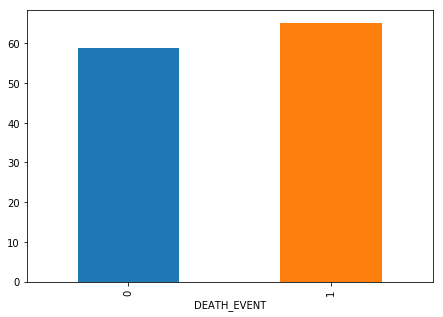

DEATH_EVENT         0         1
age_cat                        
High         0.506494  0.493506
Low          0.743243  0.256757
Medium       0.736486  0.263514


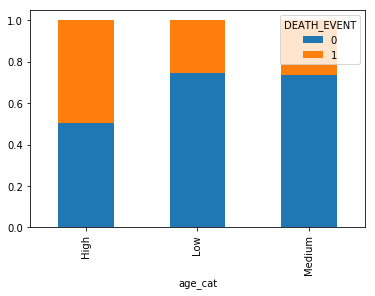

In [19]:
plt.figure(1,figsize=(16,5))
plt.subplot(121)
data.groupby(target)['age'].mean().plot.bar()
plt.show()
cross = pd.crosstab(data['age_cat'],data[target],normalize="index")
print(cross)
cross.plot.bar(stacked=True);

1. მცირედი სხვაობა არის სიკვდილის ივენთსა და არა სიკვდილის ივენთის საშუალო ასაკებს შორის.
   აშკარაა რომ საშუალოდ რაც უფრო ასაკოვანია Death-ის უფრო მეტი შანსია.
2. აქაც ჩანს რომ როცა ასაკი დიდია აშკარად უფრო მეტი შანსია სიკვდილისა, შედარებით დანარჩენი ასაკებისა.

## - creatinine_phosphokinase

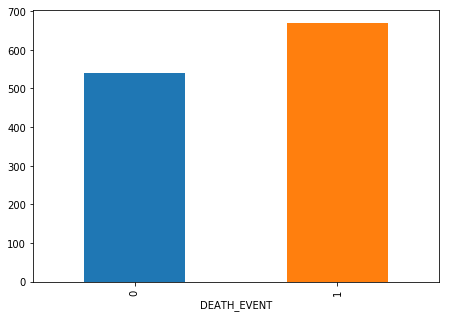

DEATH_EVENT                          0         1
creatinine_phosphokinase_cat                    
High                          0.693694  0.306306
Low                           0.746667  0.253333
Medium                        0.619469  0.380531


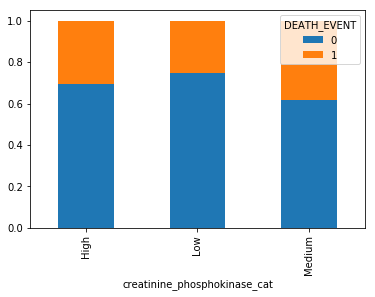

In [20]:
plt.figure(1,figsize=(16,5))
plt.subplot(121)
data.groupby(target)['creatinine_phosphokinase'].mean().plot.bar()
plt.show()
cross = pd.crosstab(data['creatinine_phosphokinase_cat'],data[target],normalize="index")
print(cross)
cross.plot.bar(stacked=True);

1. პირველიდან ჩანს რომ creatinine_phosphokinase საშუალოდ რაც უდრო მეტია მით უფრო მეტი შანსია სიკვდილისიც.
2. ჩანს რომ როცა დაბალია მისი მაჩვენებელი სიკვდილის შესაძლლებლობაც ნაკლებია. ასევე თითქოს მაღალის დროსაც დაბალია სიკვდილის შანსი.

## - ejection_fraction

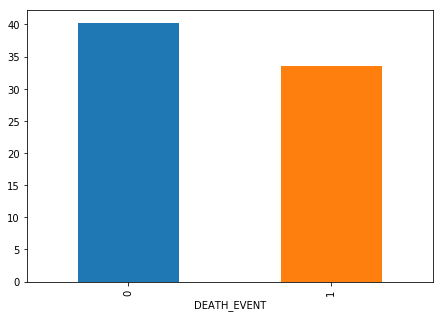

DEATH_EVENT                   0         1
ejection_fraction_cat                    
High                   0.762500  0.237500
Low                    0.355932  0.644068
Medium                 0.756250  0.243750


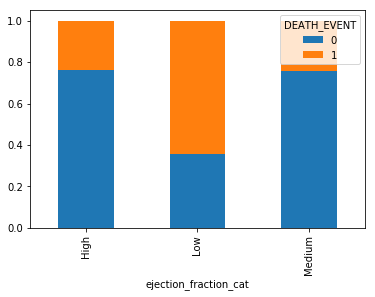

In [21]:
plt.figure(1,figsize=(16,5))
plt.subplot(121)
data.groupby(target)['ejection_fraction'].mean().plot.bar()
plt.show()
cross = pd.crosstab(data['ejection_fraction_cat'],data[target],normalize="index")
print(cross)
cross.plot.bar(stacked=True);

1. ჩანს საშუალოდ რაც უფრო ბევრია ejection_fraction, მით მეტია შანსი "კარგად ყოფნის"
2. მეორე კატეგორიზაციად დაყოფილი დიაგრამაც მაგას აჩვენებს, რომ როცა ejection_fraction არაა ცოტა (ლოუ) მაშინ ნაკლებია სიკვდილის მაჩვენებელი.

## - platelets

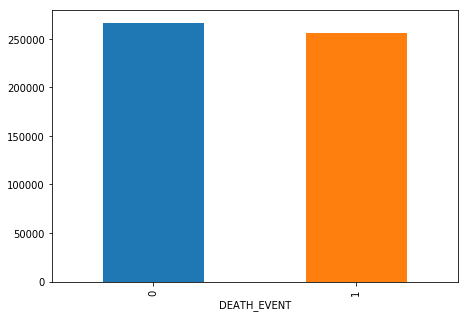

DEATH_EVENT           0         1
platelets_cat                    
High           0.653333  0.346667
Low            0.600000  0.400000
Medium         0.731544  0.268456


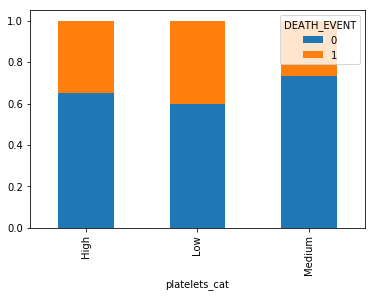

In [22]:
plt.figure(1,figsize=(16,5))
plt.subplot(121)
data.groupby(target)['platelets'].mean().plot.bar()
plt.show()
cross = pd.crosstab(data['platelets_cat'],data[target],normalize="index")
print(cross)
cross.plot.bar(stacked=True);

1. დიდი განსხვავება არაა საშუალოებს შორის და არც კატეგორიზაციით შეიმჩნევა მკვეთრად.
2. ნუ შეიძლება არის მცირე ტენდენცია, რომ რაც უფრო მაღალია platelets, მით ნაკლებია სიკვდილის შედეგი.

## - serum_creatinine

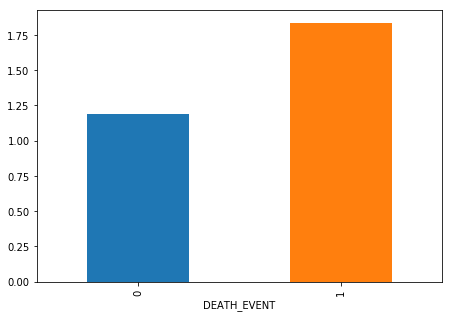

DEATH_EVENT                  0         1
serum_creatinine_cat                    
High                  0.419753  0.580247
Low                   0.918367  0.081633
Medium                0.733728  0.266272


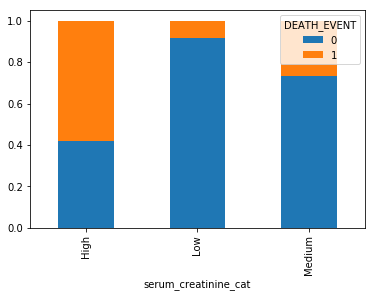

In [23]:
plt.figure(1,figsize=(16,5))
plt.subplot(121)
data.groupby(target)['serum_creatinine'].mean().plot.bar()
plt.show()
cross = pd.crosstab(data['serum_creatinine_cat'],data[target],normalize="index")
print(cross)
cross.plot.bar(stacked=True);

1. დიდი განსხვავებაა საშუალოებს შორის. რაც მეტია serum_creatinine მით მეტია სიკვდილის შედეგი.
2. აშკარა სურათია 1-ის აქაც !!!!

## - serum_sodium

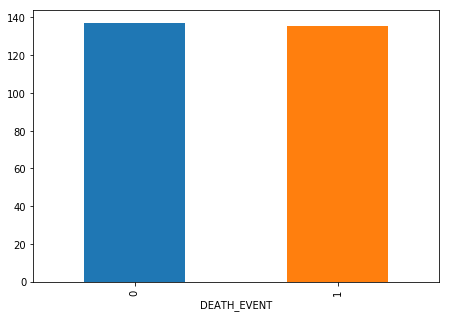

DEATH_EVENT              0         1
serum_sodium_cat                    
High              0.766234  0.233766
Low               0.509804  0.490196
Medium            0.690058  0.309942


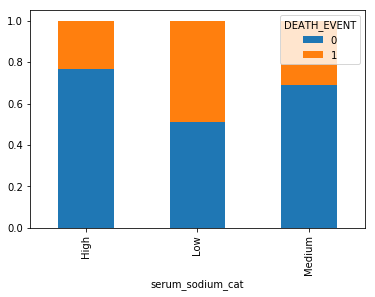

In [24]:
f = plt.figure(1,figsize=(16,5))
plt.subplot(121)
data.groupby(target)['serum_sodium'].mean().plot.bar()
plt.show()
cross = pd.crosstab(data['serum_sodium_cat'],data[target],normalize="index")
print(cross)
cross.plot.bar(stacked=True);

1. თითქოს საშუალოდ განსხვავება არაა
2. მეორედან ჩანს რომ, რაც მეტია serum_sodium მით ნაკლებია სიკვდილის შედეგი.

In [25]:
# რაც დავამატე ის უნდა წავშალო
num_cols_cat=[col+"_cat" for col in num_cols]
data = data.drop(num_cols_cat, axis=1)

# 2. მონაცემთა გარდაქმნა

--------------------------------------------------------------------------------------------------------------------------------
# ეტაპი 4-ის პასუხი


ნორმალური განაწილების მიღება გვინდა.
-- რადგან ზოგადად რთულია სწავლა ისეთი მონაცემებიდან, რომელსაც არააქვს ან ნორმალური, ან თანაბარი განაწილება.
კოვარიაციის შიფტი - ერთი ლეიერის აუთფუთი რომ გამრავლდება შემდეგი ლეიერის პარამეტრებზე, ვარიაცია იზრდება.
ვარაცია ბოლოს თუ ძაან გაგვეზარდა, მაშინ ძალიან გაუჭირდება მოდელს სქუიზი გააკეთოს ბოლოს აუთფუთ ლეიერის.

- არაპარამეტრული skewness ლექციიდან კარგად ცნობილი ნორმალიზაცია & სკალირების ერთობაა
- ხოლო moment coefficient of skewness - E[((X - mean) / variance)**3] -ესაა, ამ შემთხვევაში არ იკარგება ვარიაცია და ამითაა კარგი

# -- რიცხვითი ფიჩერების გარდაქმნა

1.  for left  skewness, take squares, qubes or higher powers
2.  for right skewness, take roots or logarithms or reciprocals (roots are weakest). 


skewness - მეოთხე ეტაპზე გვაქვს გამოთვლილი

# - age

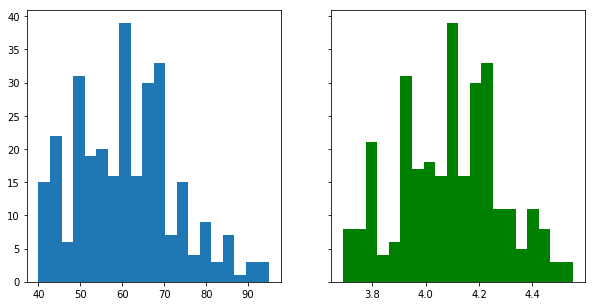

In [26]:
n_bins = 20
# ax = sns.distplot(train_df[col_name],fit=stats.norm) # -ამით ვერ ავაგე რატომღაც ვარნინგს მიგდებს ვერსიი გამო
fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=True, tight_layout=False)
# before
axs[0].hist(data[num_cols[0]], bins=n_bins);
# data[num_cols[0]] = np.sqrt(data[num_cols[0]])
data[num_cols[0]] = np.log(data[num_cols[0]])
# after
axs[1].hist(data[num_cols[0]], bins=n_bins, color='g');

## - creatinine_phosphokinase

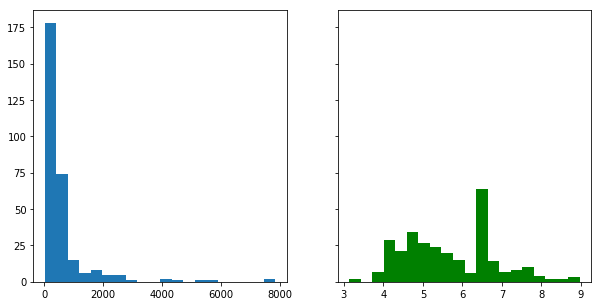

In [27]:
fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=True, tight_layout=False)
# before
axs[0].hist(data[num_cols[1]], bins=n_bins);
data[num_cols[1]] = np.log(data[num_cols[1]])
# data[num_cols[1]] = np.log1p(data[num_cols[1]])
# after
axs[1].hist(data[num_cols[1]], bins=n_bins, color='g');

# - ejection_fraction

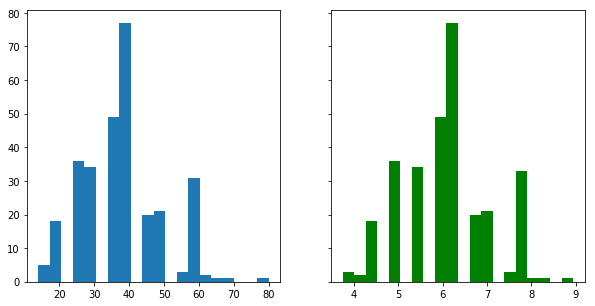

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=True, tight_layout=False)
# before
axs[0].hist(data[num_cols[2]], bins=n_bins);
data[num_cols[2]] = np.sqrt(data[num_cols[2]])
# data[num_cols[2]] = np.log1p(data[num_cols[2]])
# after
axs[1].hist(data[num_cols[2]], bins=n_bins, color='g');

ეს შედეგი მონაცემების ნაკლებობის ბრალია.

# - platelets

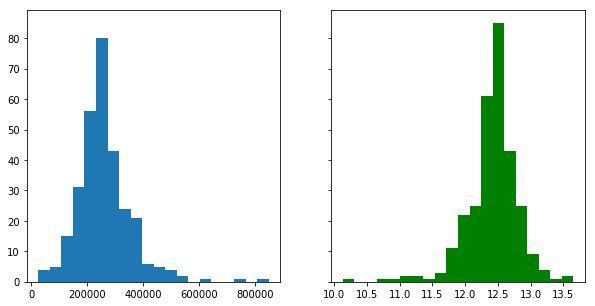

In [29]:
fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=True, tight_layout=False)
# before
axs[0].hist(data[num_cols[3]], bins=n_bins);
data[num_cols[3]] = np.log(data[num_cols[3]])
# data[num_cols[3]] = np.log1p(data[num_cols[3]])
# after
axs[1].hist(data[num_cols[3]], bins=n_bins, color='g');

# - serum_creatinine

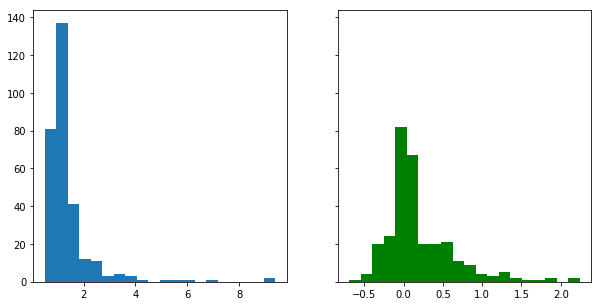

In [30]:
fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=True, tight_layout=False)
# before
axs[0].hist(data[num_cols[4]], bins=n_bins);
data[num_cols[4]] = np.log(data[num_cols[4]])
# data[num_cols[4]] = np.log1p(data[num_cols[4]])
# after
axs[1].hist(data[num_cols[4]], bins=n_bins, color='g');

# - serum_sodium

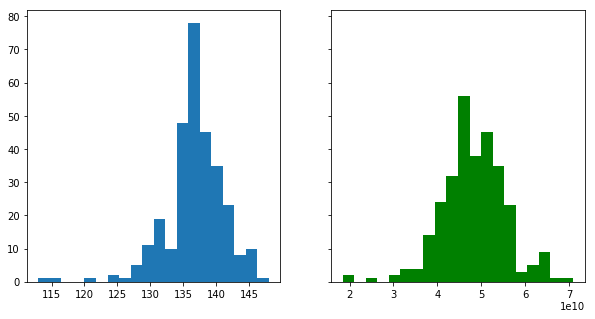

In [31]:
fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=True, tight_layout=False)
# before
axs[0].hist(data[num_cols[5]], bins=n_bins);
data[num_cols[5]] = np.power(data[num_cols[5]], 5)
# after
axs[1].hist(data[num_cols[5]], bins=n_bins, color='g');

# - time

In [32]:
# თაიმს ვაიგნორებთ
data=data.drop(['time'],axis=1)
num_cols.remove('time')

-- დამატებით სკალირების ეს მეთოდიც გამოვიყენოთ (ამით თავს იმასაც ავარიდებ რომ log-ში ნოლები ჩამჯდარიყო).

### -- normalize
შევნიშნავდით, რომ რიცხვით ცვლადებს აქვთ არანულოვანი მნიშვნელობები, ასევე მათი საშუალო არაა 1-თან. ეს შეგვიძლია გამოვასწოროთ ნორმალიზაცია, სკალირებით.
ამგვარად თავიდან ავიცილებთ მონაცემების მნიშვნელობების უცაბედ ზრდებს.

In [33]:
for i in num_cols:
    min_val=min(data[i])
    max_val=max(data[i])
    data[i]=data[i].apply(lambda a: (a-min_val)/(max_val-min_val))
for i in num_cols:
    data[i]=data[i].apply(lambda a: (a-np.mean(data[i]))/np.std(data[i]))

# -- კატეგორიული ფიჩერების გარდაქმნა

შედარებით დაუბალანსებელი ფიჩერებისთვის არსებობს რამდენიმე მიდგომა (მონაცემების გამრავლება და ჩამატება...). ჩვენ არ გვინდა რადგან საკმაოდ ნორმალურად იყო მონაცემები მოცემული 30% მეტი მაინც იყო უმცირესობა (mild არიიიიის ყველა!!!!!).

--------------------------------------------------------------------------------------------------------------------------------
# ეტაპი 5-ის მხარის აბმა


# -- კოროლაციის მატრიცი

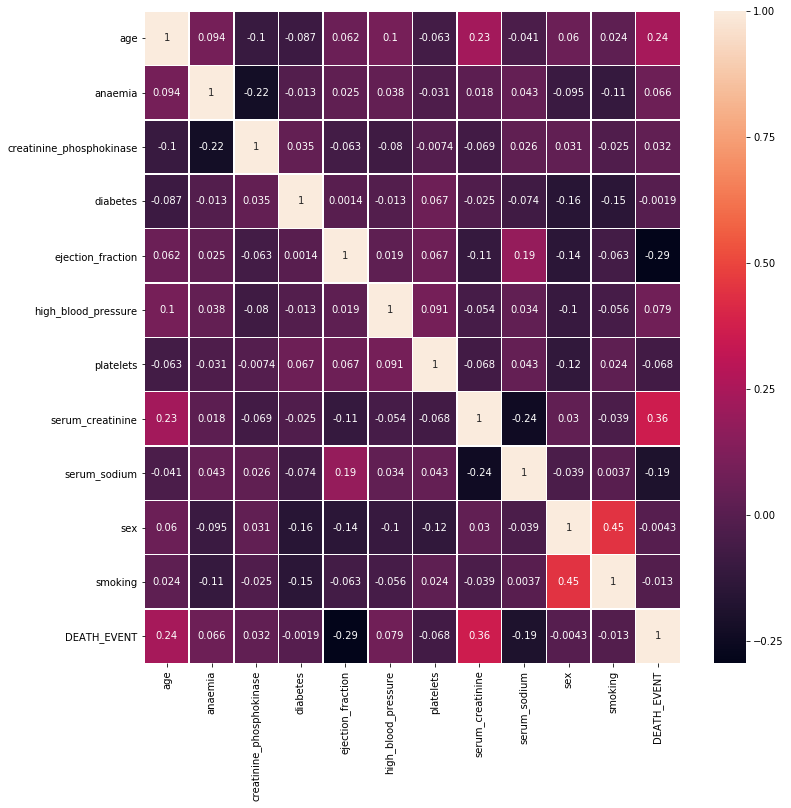

In [34]:
f, ax = plt.subplots(figsize=(12,12))
sns.heatmap(data.corr(),annot=True, linewidths=.5, ax=ax)
plt.show()

კოროლაციის მატრიცა გვიჩვენებს ურთიერთდამოკიდებულებას ფიჩერებს შორის. ეს შეიძლება გამოსადეგი იყოს მოდელის დროს. თუ კოროლაცია ახლოა და ძლიერი, ანუ მას უნდა ქონდეს გავლენა ჩვენს მოდელშიც. ამ შემთხვევაში ჩვენთვის მიშვნელოვანია სიკვდილის შედეგის დამოკიდებულება დანარჩენ ფიჩერებთან. ავიღოთ რომ თუ კოროლაცია > 0.1, ეს ფიჩერები შეიძლება იყოს მნიშვნელოვანი.

In [35]:
cor = data.corr() 
corr_target = abs(cor["DEATH_EVENT"])
relevant_features = corr_target[corr_target>0.1]
relevant_features

age                  0.240235
ejection_fraction    0.294260
serum_creatinine     0.360301
serum_sodium         0.189253
DEATH_EVENT          1.000000
Name: DEATH_EVENT, dtype: float64

-- ზუსტად ეს ფაქტი კარგად ჩანდა ჩვენს ყოველ ეტაპზე, განსაკუთრებით 1 ნაბიჯის (მონაცემთა ანალიზი) მე-5 ეტაპზე!!!

--------------------------------------------------------------------------------------------------------------------------------
# ეტაპი 3-ის პასუხი


In [36]:
# კატეგორიული ცვლადების შემთხვევაში ჩანდა რომ დიდი მეხსიერება იყო გამოყოფილი, 
# რასაც შევამცირებ (ეს ეტაპი აქ, მცირე მონაცემების დროს) არაა სავალდებულო
dic = {}
for col in cat_cols:
    dic[col] = 'int8'
data.astype(dic).dtypes

age                         float64
anaemia                        int8
creatinine_phosphokinase    float64
diabetes                       int8
ejection_fraction           float64
high_blood_pressure            int8
platelets                   float64
serum_creatinine            float64
serum_sodium                float64
sex                            int8
smoking                        int8
DEATH_EVENT                    int8
dtype: object

--------------------------------------------------------------------------------------------------------------------------------

# - Baseline model

In [37]:
# 1-იანების სვეტი ალგორითმის სწორად სამუშაოდ (თავისუფალი წევრი რომ გაჩნდეს პოლინომიალურ განტოლებაში)
data.insert(0, 'Ones', 1)

# X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]

# მონაცემების მასივად წარმოდგენა, და საწყისი თეტა მასივის ინიციალიზაცია
X = np.array(X.values)
y = np.array(y.values)
theta = np.zeros(cols - 1)

X.shape, theta.shape, y.shape

((299, 12), (12,), (299, 1))

### - ეტაპი 1-ის პასუხი

სფლითის მეშვეობით ტრეინინგ სეტსა და ტესტ სეტს ერთმანეთისგან ვყოფთ.
რადგან ამ შემთხვევაში მონაცემები ცოტაა, ამიტომ 25% ვტოვებ ტესტირებისთვის.
random_state მონაცემებს ანაცვლებს, თუ რევს, გაუმჯობესებისთვის დაიმახსოვრე

In [38]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.18, random_state = 0)
print("Train distribution",y_train.mean(), "\n",sep="\n")
print("Test distribution",y_test.mean(),sep="\n")

Train distribution
0.31020408163265306


Test distribution
0.37037037037037035


შესაძლებელი oversampling - ის ცდა ---- smoke ალგორითმი

In [39]:
x_train.shape, theta.shape, y_train.shape

((245, 12), (12,), (245, 1))

# 3. მოდელის იმპლემენტაცია

In [40]:
accuracy_list = {}

### --- სიზუსტის მთვლელი (ზოგადად გამოსადეგი მეთოდები)

In [41]:
def predict(theta, X):
    probability = sigmoid(X * theta.T)
    return [1 if x >= 0.5 else 0 for x in probability]

In [42]:
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, confusion_matrix
def accuracy(theta, x_test, y_test):
    y_pred = predict(np.matrix(theta),x_test)
    return accuracy_score(y_test, y_pred)

 # Logistic Regression

სიგმოიდს ვიყენებთ იმისთვის, რომ h(X) დანორმალიზირდეს ([0,1]), მერე კლასიფიკაცია მოვახდენთ Theschold-ით.

In [43]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [44]:
def hypothesis(X, theta):
    return sigmoid(X * theta.T)

calculate_cost-ი ითვლის თუ რა სიზუსტით ჩავარდა მონაცემები სწორ კლასში.

In [45]:
def calculate_cost(theta, X, y):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    first = np.multiply(-y, np.log(hypothesis(X, theta)))
    second = np.multiply((1 - y), np.log(1 - hypothesis(X, theta)))
    return np.sum(first - second) / (len(X))

In [46]:
calculate_cost(theta, x_train, y_train)

0.6931471805599453

დავაკვირდეთ საწყის ქოსთს, გვინდა ამ მაჩვენებელმა დაიკლოს ნელ-ნელა.

In [47]:
def gradient(theta, X, y):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    # ითვლის ფიჩერების რაოდენობას, რათა თითოეულისთვის მოახდინოს
    # მათი თეტას აფდეითისთვის სწორი შენამატის განსაზღვრა (- a * grad).
    parameters = int(theta.ravel().shape[1])
    # ესაა თითოეული ფიჩერისთვის დასათვლელი გრადებისთვის ადგილი
    grad = np.zeros(parameters)
    # ეს არ იცვლება ფიჩერების მიხედვით, ამიტომ აქ ვთვლი
    error = hypothesis(X, theta) - y
    for i in range(parameters):
        # ფორმულას მიყვება შესაბამის ფიჩერის სვეტზე მრავლდება ერორი
        term = np.multiply(error, X[:,i])
        # იჯამება შედეგი
        grad[i] = np.sum(term)
        grad[i] = grad[i] / len(X)
    return grad

In [48]:
gradient(theta, x_train, y_train)

array([ 0.18979592, -0.10916325,  0.06734694, -0.00617283,  0.06938776,
        0.14776716,  0.04897959,  0.03596946, -0.16318812,  0.09145443,
        0.13061224,  0.06734694])

In [49]:
def logistic_regression(X, y, theta, alpha, iters):
    cost_arr = np.zeros(iters)
    for i in range(iters):
        term = (alpha * np.matrix(gradient(theta, X, y))).T
        term = np.squeeze(np.asarray(term))
        theta = theta - term
        cost_arr[i] = calculate_cost(theta, X, y)
    return theta, cost_arr

პატარა ალფათი ვიწყებ მე, რათა დავინახო ტენდენცია ქოსთის კლების მიდის თუ არა ამ კონკრეტული მნიშვნელობისთვის, თუ ასეა ალფას გავზრდი ნელ-ნელა იქამდე სადამდეც დავინახავ რომ ქოსთის საბოლოო იტერაციის შეფასება მინიმალურია და მეტი აღარ მცირდება

In [50]:
#------------------------------ 1 --------------------------------------
alpha = 0.1
iters = 3000
g, cost_num = logistic_regression(x_train, y_train, theta, alpha, iters)
cost_num

array([0.6795024 , 0.6670016 , 0.65554018, ..., 0.46812851, 0.46812851,
       0.46812851])

In [51]:
calculate_cost(g, x_train, y_train)

0.4681285074310204

In [52]:
#------------------------------ 2 --------------------------------------
alpha = 0.5
iters = 3000
g, cost_num = logistic_regression(x_train, y_train, theta, alpha, iters)
cost_num

array([0.63088228, 0.59177752, 0.56608456, ..., 0.46812741, 0.46812741,
       0.46812741])

In [53]:
calculate_cost(g, x_train, y_train)

0.46812741019691895

In [54]:
#------------------------------ 3 --------------------------------------
alpha = 1
iters = 10000
g, cost_num = logistic_regression(x_train, y_train, theta, alpha, iters)
cost_num, g

(array([0.58311012, 0.54181871, 0.52151597, ..., 0.46812741, 0.46812741,
        0.46812741]),
 array([-1.2474026 ,  0.65193337,  0.33616053,  0.17428285,  0.22811688,
        -0.94408434,  0.51968079, -0.07858606,  0.65309912, -0.16424276,
        -0.50005799,  0.00857745]))

In [55]:
calculate_cost(g, x_train, y_train)

0.4681274101969189

აქ გავჩერდებით, რადგან წესით მაქსიმუმია. და აწი უფრო ზუსტი მონაცემის მიღება იტერაციის გაზრდითაა შესალებელი.

--- ესაა თავად ბიბლიოთეკა რომელიც ოპტიმიზაციასაც უკეთებს შედეგს (მინიმალიზაციას აკეთებს ქოსთისას)

In [56]:
import scipy.optimize as opt
result = opt.fmin_tnc(func=calculate_cost, x0=theta, fprime=gradient, args=(x_train, y_train))
result

(array([-1.24739839,  0.65193795,  0.33616203,  0.17428234,  0.22809983,
        -0.94408789,  0.51968701, -0.07857931,  0.65309989, -0.16424214,
        -0.50006985,  0.00858638]), 37, 1)

In [57]:
calculate_cost(result[0], x_train, y_train)

0.4681274102133499

ვხედავთ რომ არც მინიმალური ქოსთი არის ჩვენისგან დიდად განსხვავებული, ცოტა უფრო ზუსტია

|||| ზოგადად გამოდის რომ ქოსთი თავდაპირველთან შედარებით უფრო მცირეა ნამდვილად.

### --- სიზუსტე რამდენი პროცენტია?

In [58]:
accuracy(g, x_train, y_train), accuracy(result[0], x_train, y_train)

(0.7836734693877551, 0.7836734693877551)

გამოვიდა რომ 78%-ში სწორი პასუხი მომცა ტესტ სეტზე (მშვენიერი შედეგია)

In [59]:
acc = accuracy(result[0], x_test, y_test)
accuracy_list['logistic regression'] = acc
accuracy(g, x_test, y_test), acc

(0.7407407407407407, 0.7407407407407407)

# 4. ოპტიმიზაცია

# Regularized Logistic Regression

In [60]:
def costReg(theta, X, y, learningRate):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    first = np.multiply(-y, np.log(sigmoid(X * theta.T)))
    second = np.multiply((1 - y), np.log(1 - sigmoid(X * theta.T)))
    reg = (learningRate / 2 * len(X)) * np.sum(np.power(theta[:,1:theta.shape[1]], 2))
    return np.sum(first - second) / (len(X)) + reg

In [61]:
# ამასაც ჩავწერდი ზედა ლოგისტიკური რეგრესიის მსგავსად თავისი იტერაციებით ხელით, მაგრამ ამდენი რაღაცის მერე იყოს ასე...
def gradientReg(theta, X, y, learningRate):
    theta = np.matrix(theta)
    X = np.matrix(X)
    y = np.matrix(y)
    parameters = int(theta.ravel().shape[1])
    grad = np.zeros(parameters)
    error = sigmoid(X * theta.T) - y
    for i in range(parameters):
        term = np.multiply(error, X[:,i])
        # ეს ნაწილია განსხვავებილი, პირველი თეტასთვის ცალკე შემთხვევაა (რადგან მას მეწყვილე ფიჩერი არა ყავს)
        if (i == 0):
            grad[i] = np.sum(term) / len(X)
        else:
            grad[i] = (np.sum(term) / len(X)) + ((learningRate / len(X)) * theta[:,i])
    return grad

In [62]:
learningRate = 1

In [63]:
costReg(theta, x_train, y_train, learningRate)

0.6931471805599453

In [64]:
gradientReg(theta,  x_train, y_train , learningRate)

array([ 0.18979592, -0.10916325,  0.06734694, -0.00617283,  0.06938776,
        0.14776716,  0.04897959,  0.03596946, -0.16318812,  0.09145443,
        0.13061224,  0.06734694])

In [65]:
result_reg = opt.fmin_tnc(func=costReg, x0=theta, fprime=gradientReg, args=(x_train, y_train, learningRate))
result_reg

(array([-7.70571921e-04,  7.38616511e-04, -1.46742605e-04,  6.57265559e-05,
        -1.88729798e-04, -1.03250706e-03, -1.81258360e-05, -9.95179439e-05,
         9.29151533e-04, -4.02649348e-04, -5.24772715e-04, -2.43652188e-04]),
 90,
 1)

In [66]:
costReg(result_reg[0], x_train, y_train, learningRate)

0.6928399670654078

### --- სიზუსტე რამდენი პროცენტია?

In [67]:
acc = accuracy(result_reg[0], x_test, y_test)
accuracy_list['regularized logistic regression'] = acc
accuracy(result_reg[0], x_train, y_train), acc

(0.7918367346938775, 0.7407407407407407)

ცოტათი თუმცა ჩანს რომ რეგულარიზაციას თან შედეგები ახლავს.

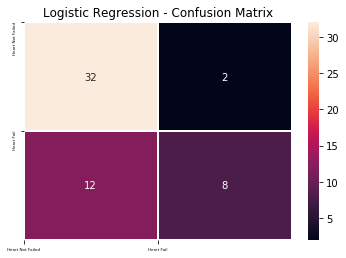

In [68]:
# გამოდის რომ 
cm = confusion_matrix(y_test,predict(np.matrix(result[0]),x_test))
sns.heatmap(cm,annot=True, linewidths=1)
plt.title("Logistic Regression - Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=4)
plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=4)
plt.show()

12 შემთხვევაში ვარაუდობს რომ არ უნდა დასრულდეს სიკვდილით, თუმცა სრულდება. 
8 შემთხვევაში ფიქრობს რომ უნდა დასრულდეს მაგრამ არა. 

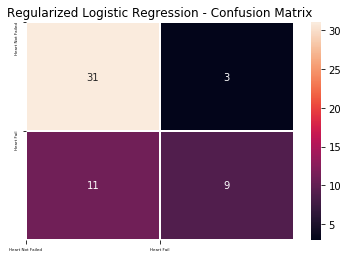

In [69]:
cm = confusion_matrix(y_test,predict(np.matrix(result_reg[0]),x_test))
sns.heatmap(cm,annot=True, linewidths=1)
plt.title("Regularized Logistic Regression - Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=4)
plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=4)
plt.show()

აქ 11/9-ზე. დიდი განსხვავებაა არაა.

#### კარგი იქნებოდა დაკვირვება რა შემთხვევაში ცდება ალგორითმი და შეცდომასა და ფიჩერებს შორის რამე კავშირი არის თუ არა

#### და ფიჩერების გადაყრა წაგვეხმარებოდა თუ არა

-- კატეგორიულებიდან მოვიშოროთ ყველა, რადგან მეხუთე ეტაპზე ჩანს კარგად რომ სიკვდილის შედეგთან მიმართებით ბევრს არაფერს ამბობდნენ.
ასევე რიცხვითი ცვლადებიდან უკვე გავფილტრე კოროლაციის მეშვეობით ფიჩერები და მრჩებოდა --->
age                  0.240235
ejection_fraction    0.294260
serum_creatinine     0.360301
serum_sodium         0.189253

In [70]:
#data=data.drop(['anaemia'],axis=1)
#cat_cols.remove('anaemia')
data=data.drop(['creatinine_phosphokinase'],axis=1)
num_cols.remove('creatinine_phosphokinase')
data=data.drop(['diabetes'],axis=1)
cat_cols.remove('diabetes')
#data=data.drop(['high_blood_pressure'],axis=1)
#cat_cols.remove('high_blood_pressure')
data=data.drop(['platelets'],axis=1)
num_cols.remove('platelets')
data=data.drop(['sex'],axis=1)
cat_cols.remove('sex')
data=data.drop(['smoking'],axis=1)
cat_cols.remove('smoking')
data.head()

,Ones,age,anaemia,ejection_fraction,high_blood_pressure,serum_creatinine,serum_sodium,DEATH_EVENT
0,1,1.171715,0,-1.706438,1,0.979921,-1.494279,1
1,1,-0.420357,0,0.070509,0,-0.228312,-0.212718,1
2,1,0.437157,0,-1.706438,0,0.140991,-1.686071,1
3,1,-0.909598,1,-1.706438,0,0.979921,0.024027,1
4,1,0.437157,1,-1.706438,0,1.756749,-3.693622,1


In [71]:
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]

X = np.array(X.values)
y = np.array(y.values)
theta = np.zeros(cols - 1)

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.18, random_state = 0)

In [72]:
result = opt.fmin_tnc(func=calculate_cost, x0=theta, fprime=gradient, args=(x_train, y_train))
result

(array([-1.42157484,  0.60636693,  0.28634282, -0.91674071,  0.54834284,
         0.61285947, -0.15491095]), 23, 1)

In [73]:
acc = accuracy(result[0], x_test, y_test)
accuracy_list['trimed logistic regression'] = acc
accuracy(result[0], x_train, y_train), acc

(0.7755102040816326, 0.7222222222222222)

In [74]:
result_reg = opt.fmin_tnc(func=costReg, x0=theta, fprime=gradientReg, args=(x_train, y_train, learningRate))
result_reg

(array([-2.71320424e-03,  1.67416424e-03, -4.25131455e-04, -2.26140753e-03,
        -4.47384407e-06,  1.66602376e-03, -2.09499017e-04]), 90, 4)

In [75]:
acc = accuracy(result_reg[0], x_test, y_test)
accuracy_list['trimed regularized logistic regression'] = acc
accuracy(result_reg[0], x_train, y_train), acc

(0.7795918367346939, 0.7037037037037037)

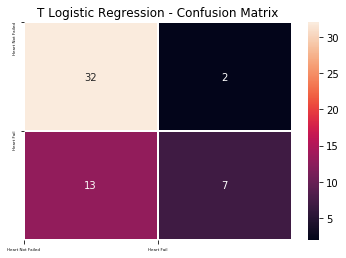

In [76]:
cm = confusion_matrix(y_test,predict(np.matrix(result[0]),x_test))
sns.heatmap(cm,annot=True, linewidths=1)
plt.title("T Logistic Regression - Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=4)
plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=4)
plt.show()

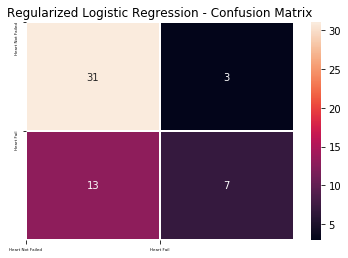

In [77]:
cm = confusion_matrix(y_test,predict(np.matrix(result_reg[0]),x_test))
sns.heatmap(cm,annot=True, linewidths=1)
plt.title("Regularized Logistic Regression - Confusion Matrix")
plt.xticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=4)
plt.yticks(range(2), ["Heart Not Failed","Heart Fail"], fontsize=4)
plt.show()

ჩანს სიზუსტე ამ ფიჩერების დადროფვით არ გაუმჯობესდა, შეიძლება ამ ტესტ მონაცემებზე (შეიძლება ისე უკეთესი შედეგიც მოეცა)

In [78]:
# ბოლო ნაწილი შეიძლება წამეშალა რადგან ბევრს არაფერს იძლევა